# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev1 toc-item"><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></div><div class="lev1 toc-item"><a href="#Optimize-hyperparameters-using-district-27" data-toc-modified-id="Optimize-hyperparameters-using-district-27-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimize hyperparameters using district 27</a></div><div class="lev1 toc-item"><a href="#Get-posterior-mean-$\hat\beta$" data-toc-modified-id="Get-posterior-mean-$\hat\beta$-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get posterior mean $\hat\beta$</a></div><div class="lev1 toc-item"><a href="#Fit-GPs-to-residuals" data-toc-modified-id="Fit-GPs-to-residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fit GPs to residuals</a></div><div class="lev1 toc-item"><a href="#Pairwise-treatment-effect" data-toc-modified-id="Pairwise-treatment-effect-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pairwise treatment effect</a></div><div class="lev1 toc-item"><a href="#Next-steps" data-toc-modified-id="Next-steps-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Next steps</a></div><div class="lev1 toc-item"><a href="#Optimizing-hyperparameters-using-multiple-districts" data-toc-modified-id="Optimizing-hyperparameters-using-multiple-districts-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Optimizing hyperparameters using multiple districts</a></div><div class="lev2 toc-item"><a href="#subset-of-districts" data-toc-modified-id="subset-of-districts-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>subset of districts</a></div><div class="lev1 toc-item"><a href="#Get-posterior-mean-$\beta$-using-multiple-districts" data-toc-modified-id="Get-posterior-mean-$\beta$-using-multiple-districts-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Get posterior mean $\beta$ using multiple districts</a></div><div class="lev1 toc-item"><a href="#Fit-residuals-with-new-$\hat\beta$-and-hyperparameters" data-toc-modified-id="Fit-residuals-with-new-$\hat\beta$-and-hyperparameters-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Fit residuals with new $\hat\beta$ and hyperparameters</a></div><div class="lev1 toc-item"><a href="#Parwise-treatment-effect" data-toc-modified-id="Parwise-treatment-effect-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Parwise treatment effect</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\scrl}{\mathscr{l}}
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\trans}{^{\intercal}}
$$

The New York City school district is itself divided into sub-districts. From now on, by “district”, I will be talking about these sub-districts. Residents are guaranteed a slot in a school within their district, but there is some system whereby a child can apply to attend schools outside of the district, which might possibly dampen the treatment effect.

Our goal is to detect discontinuities in the price of housing across the school district boundaries.

In [3]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
import Base: mean
using Distributions
using Base.LinAlg
using Distances
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats

import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [4]:
module GeoRDD
    using GaussianProcesses
    include("../src/cliff_face.jl")
    include("../src/point_estimates.jl")
end

GeoRDD

In [73]:
NYC_sales=readtable("NYC_data/processed/NYC_sales.csv", header=true)
# categorical variables
categorical!(NYC_sales, [:BOROUGH,
    :BUILDING_CLASS_CATEGORY,
    :BUILDING_CLASS_AT_TIME_OF_SALE,
    :ZIP_CODE,
    :TAX_CLASS_AT_PRESENT,
    :TAX_CLASS_AT_TIME_OF_SALE,
    :NEIGHBORHOOD,
    ])   

In [74]:
residential = Dict(
"01  ONE FAMILY DWELLINGS"=>true,
"02  TWO FAMILY DWELLINGS"=>true,
"03  THREE FAMILY DWELLINGS"=>true,
"04  TAX CLASS 1 CONDOS"=>true,
"05  TAX CLASS 1 VACANT LAND"=>false,
"06  TAX CLASS 1 - OTHER"=>false,
"07  RENTALS - WALKUP APARTMENTS"=>false,
"08  RENTALS - ELEVATOR APARTMENTS"=>false,
"09  COOPS - WALKUP APARTMENTS"=>true,
"10  COOPS - ELEVATOR APARTMENTS"=>true,
"11  SPECIAL CONDO BILLING LOTS"=>false,
"11A CONDO-RENTALS"=>false,
"12  CONDOS - WALKUP APARTMENTS"=>true, # why are these duplicated?
"13  CONDOS - ELEVATOR APARTMENTS"=>true,
"14  RENTALS - 4-10 UNIT"=>false,
"15  CONDOS - 2-10 UNIT RESIDENTIAL"=>true,
"16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT"=>false,
"17  CONDO COOPS"=>true,
"18  TAX CLASS 3 - UNTILITY PROPERTIES"=>false,
"21  OFFICE BUILDINGS"=>false,
"22  STORE BUILDINGS"=>false,
"23  LOFT BUILDINGS"=>false,
"25  LUXURY HOTELS"=>false,
"26  OTHER HOTELS"=>false,
"27  FACTORIES"=>false,
"28  COMMERCIAL CONDOS"=>false,
"29  COMMERCIAL GARAGES"=>false,
"30  WAREHOUSES"=>false,
"31  COMMERCIAL VACANT LAND"=>false,
"32  HOSPITAL AND HEALTH FACILITIES"=>false,
"33  EDUCATIONAL FACILITIES"=>false,
"34  THEATRES"=>false,
"35  INDOOR PUBLIC AND CULTURAL FACILITIES"=>false,
"36  OUTDOOR RECREATIONAL FACILITIES"=>false,
"37  RELIGIOUS FACILITIES"=>false,
"38  ASYLUMS AND HOMES"=>false,
"41  TAX CLASS 4 - OTHER"=>false,
"42  CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC"=>false,
"43  CONDO OFFICE BUILDINGS"=>false,
"44  CONDO PARKING"=>false,
"45  CONDO HOTELS"=>false,
"46  CONDO STORE BUILDINGS"=>false,
"47  CONDO NON-BUSINESS STORAGE"=>false,
"48  CONDO TERRACES/GARDENS/CABANAS"=>false,
"49  CONDO WAREHOUSES/FACTORY/INDUS"=>false,
);

In [75]:
NYC_sales[:logSalePricePerSQFT] = map(log, NYC_sales[:SALE_PRICE]; lift=true) .- map(log, NYC_sales[:GROSS_SQUARE_FEET]; lift=true)
believable = zeros(Bool, size(NYC_sales,1))
removed=zeros(Int, 12)
for i in 1:size(NYC_sales,1)
    if NYC_sales[i,:SALE_PRICE].isnull
        removed[1] += 1
        continue
    end
    if get(NYC_sales[i,:SchDistr])==0
        removed[2] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_AT_TIME_OF_SALE].isnull
        removed[3] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[4] += 1
        continue
    end
    if !residential[get(NYC_sales[i,:BUILDING_CLASS_CATEGORY])]
        removed[5] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[6] += 1
        continue
    end
    if NYC_sales[i,:TAX_CLASS_AT_TIME_OF_SALE].isnull
        removed[7] += 1
        continue
    end
    if NYC_sales[i,:GROSS_SQUARE_FEET].isnull
        removed[8] += 1
        continue
    end
    if get(NYC_sales[i,:GROSS_SQUARE_FEET])<100.0
        removed[9] += 1
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) < 3.0
        removed[10] += 1
        # that's too cheap
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) > 8.0
        removed[11] += 1
        # that's too expensive
        continue
    end
    if NYC_sales[i,:X_PRJ].isnull
        removed[12] += 1
        continue
    end
    if NYC_sales[i,:Y_PRJ].isnull
        removed[13] += 1
        continue
    end
    believable[i] = true
end

nobsv_ = sum(believable)
for_mm = copy(NYC_sales[believable,:])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr].values)
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr].values .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{Int,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr].values .== name)
    schdistr_indices[name] = indices
end
;
Y_dict=Dict{Int, Vector{Float64}}()
X_dict=Dict{Int, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePricePerSQFT]
    X_dict[name] = for_mm[schdistr_indices[name],[:X_PRJ, :Y_PRJ]]
end
sentinels_json=GeoJSON.parsefile("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{Int,Int},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [76]:
removed

12-element Array{Int64,1}:
     0
 55817
     0
     0
    58
     0
     0
   403
     0
    23
     0
     0

In [10]:
s=String(get(NYC_sales[5,:BUILDING_CLASS_AT_TIME_OF_SALE]))[1] ∉

LoadError: syntax: incomplete: premature end of input

In [11]:
methodswith(typeof(s))

LoadError: UndefVarError: s not defined

In [12]:
String(s)

LoadError: UndefVarError: s not defined

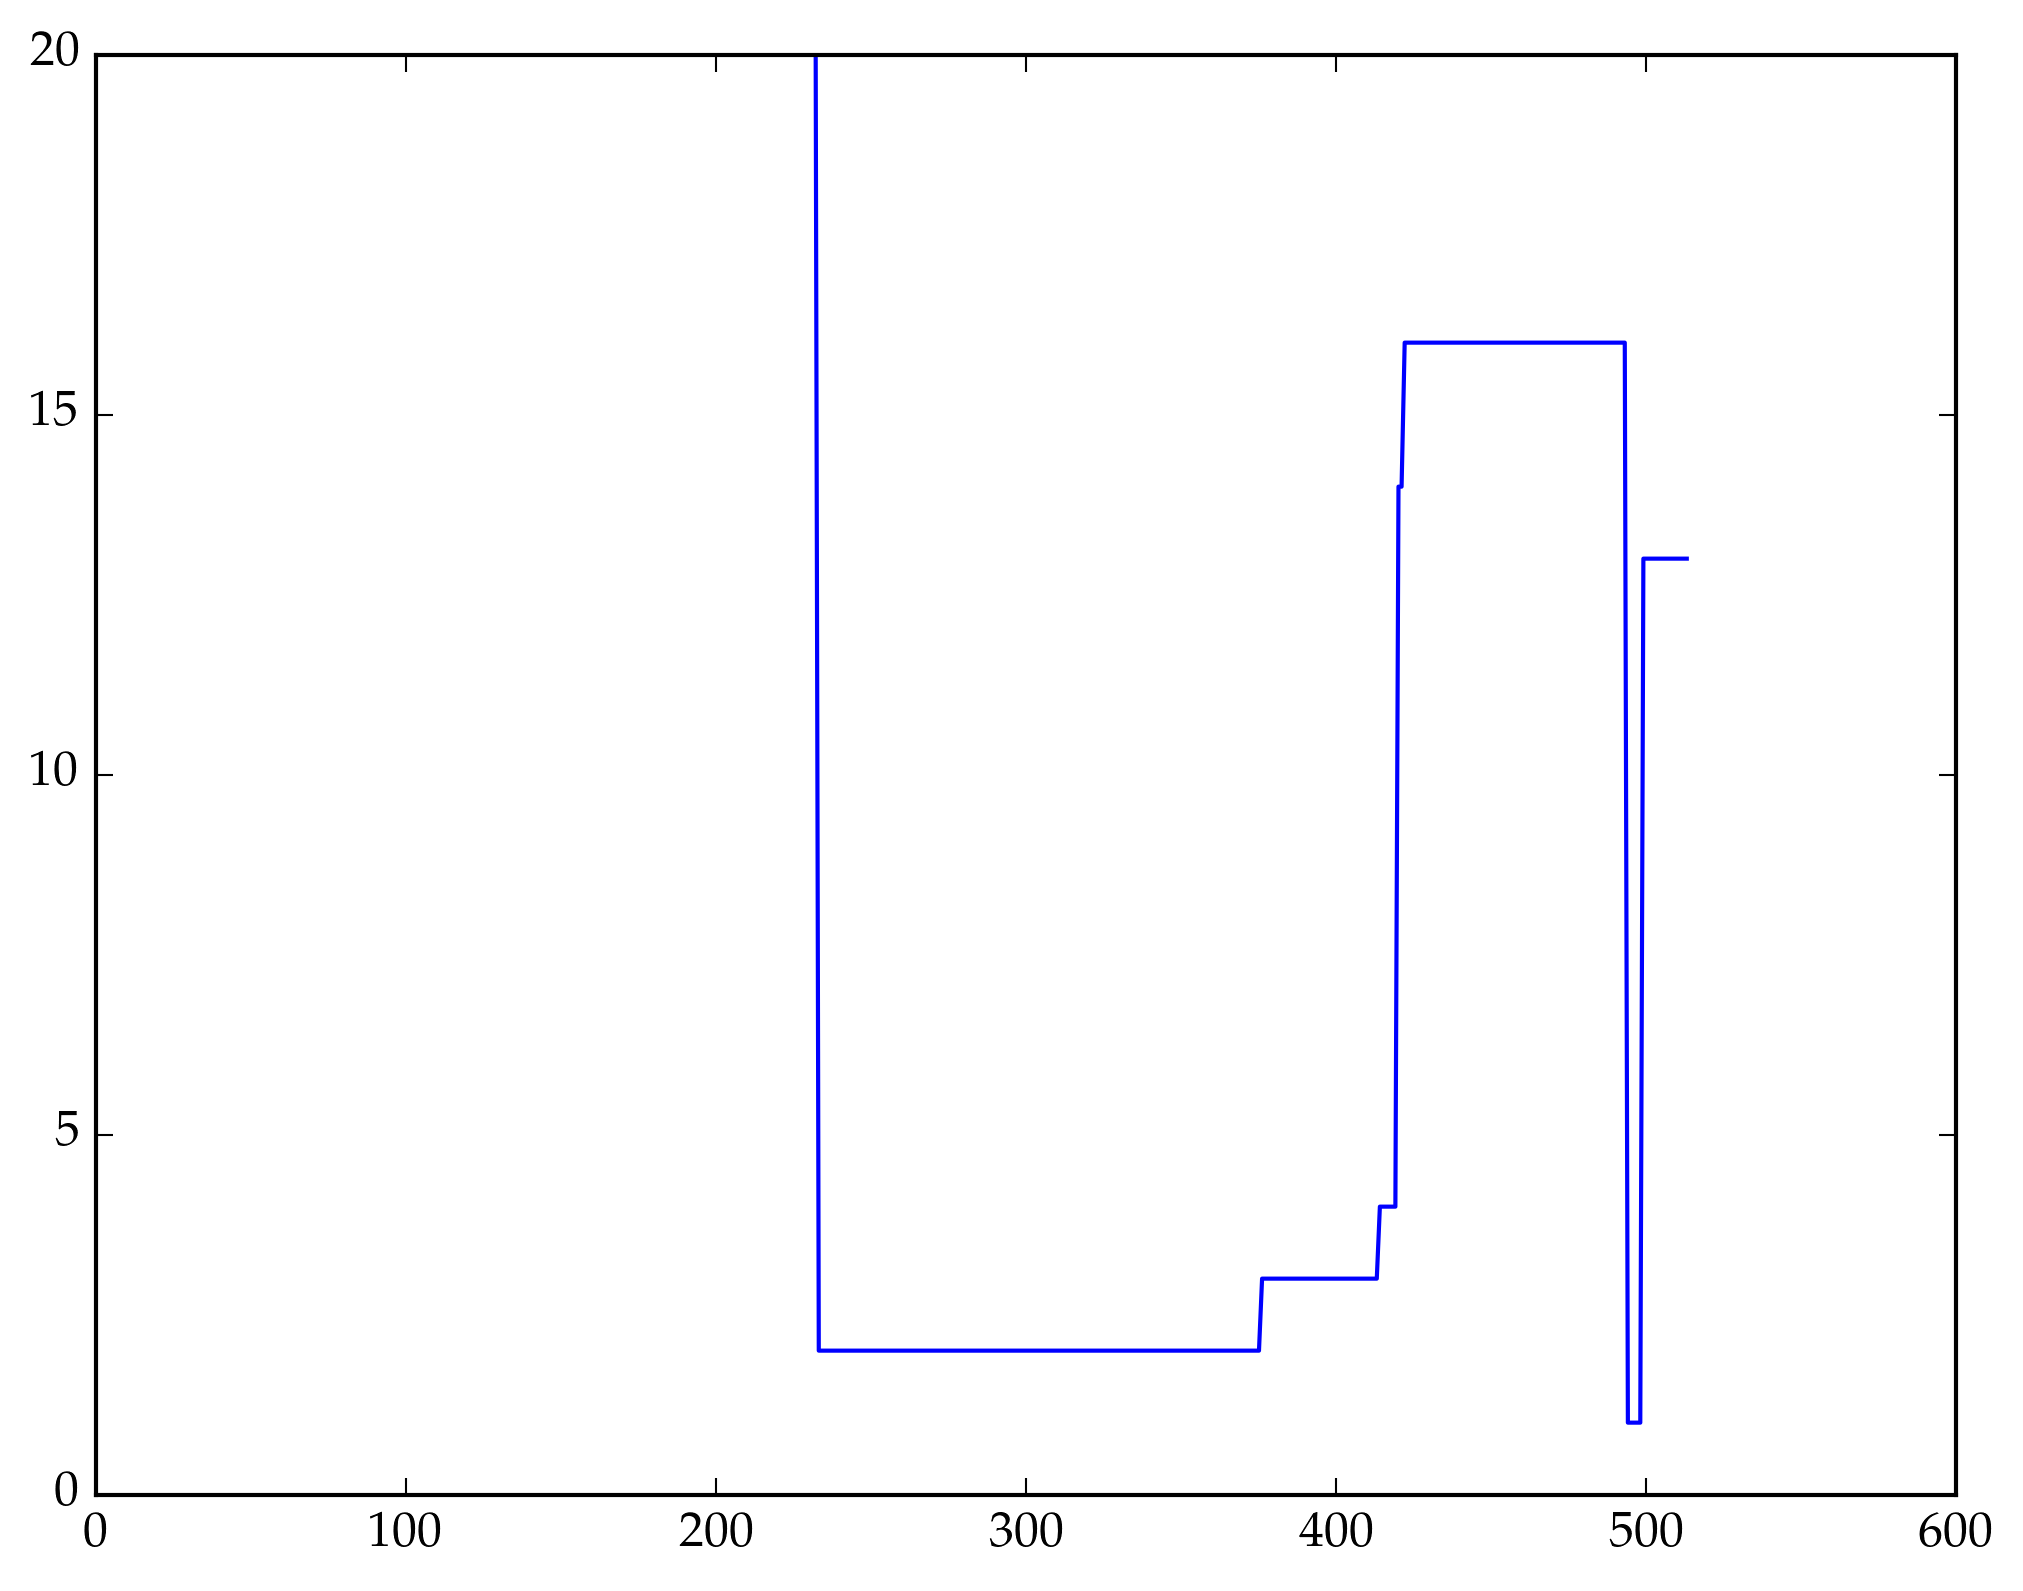

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32c9b5450>

In [13]:
plt.plot(for_mm[:SchDistr].values)

# Dataset

New York publishes a year's worth of house sales on a rolling basis. Annoyingly, this means that data that is older than a year disappears, and I've not been able to find this data online. But New York is a density, so even just a year's data is quite a large dataset.

I also have some covariates, though somewhat less rich than I found in Tucson. What I have is square footage, tax class and [building class](http://nycprop.nyc.gov/nycproperty/help/hlpbldgcode.html). I've geocoded the address of each sale to get a latitude and longitude, and projected the coordinates onto a Euclidean plane in order to be able to calculate distances.

![sales map](NYC_plots/NYC_sales.png)

## Data cleaning

I remove the following sales:

* any sale with missing data in the sale price, square footage, property covariates, geographical coordinates (due to failed geocoding)
* sales outside of any NYC school district
* properties smaller than 100 sq ft
* outliers in the price per sqft, which I defined as sales outside of $3 < Y_i < 8$

I remove tiny properties because I feel like they might behave differently than the rest of the market.
Removing outliers is possibly contentious, but it makes sense to me that some sales between friends or family members could have a very low $Y_i$ that isn't a true representation of the market price, and that some high prices could be equally disconnected from the market.

This leaves {{sum(believable)}} out of {{length(believable)}} sales records in NYC, mostly because of properties that don't have a reported gross square footage.

# Model

I decided to define the outcome to be the log price per square foot. The model is a Gaussian Process in the spatial covariates on top of a ridge regression on the property covariates (building and tax class). Within a school district we could write the model as [suggestions for clearer notation welcome]:

\begin{align}
    Y_i &= \log\del{ \frac{\saleprice_i}{\sqft_i}} = \beta_0 + \beta_{1\tax\sbr{i}} + \beta_{2\building\sbr{i}} + f(\xvec_i) + \epsilon_i \\
    \epsilon_i &\sim \normal\del{0, \sigma_y^2} \\
    \beta_{1j},\beta_{2j} &\sim \normal\del{0, \sigma_\beta^2} \\
    f(\xvec_i) &\sim \GP\del{0, k(\xvec, \xvec')} \\
    k(\xvec, \xvec') &= \sigma_f^2 \exp\cbr{ - (\xvec-\xvec')\trans(\xvec-\xvec') / 2\scrl^2}
\end{align}

A visual inspection of the house sales map above led me to focus on the boundary between districts 19 and 27. I found a map online of average maths performance in each school district, which shows that districts 19 and 27 are quite different. It's important to note that the boundary between the two districts is also part of the boundary between Brooklyn and Queens, so we won't be able to attribute a causal effect solely to the difference in school districts. A histogram of $Y$ in both districts also shows that marginally the house prices are very different.

![districts](NYC_plots/NYC_school_performances_croppped.png)

In [16]:
distrA = 19
distrB = 27
plt.plt[:hist](Y_dict[distrA],bins=50, histtype="step", label=@sprintf("district %d", distrA), linewidth=2)
plt.plt[:hist](Y_dict[distrB],bins=50, histtype="step", label=@sprintf("district %d", distrB), linewidth=2)
plt.title("Histogram of log prices per sqft")
plt.legend(loc="upper left")
;

LoadError: KeyError: key 19 not found

In [17]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePricePerSQFT ~ BUILDING_CLASS_AT_TIME_OF_SALE + TAX_CLASS_AT_TIME_OF_SALE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [18]:
σβ = 1.0
βkern_ = GaussianProcesses.LinIso(log(σβ))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end

In [19]:
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end
function get_ααinvcKI!(ααinvcKI::Matrix, cK::AbstractPDMat, α::Vector)
    nobsv = length(α)
    size(ααinvcKI) == (nobsv, nobsv) || throw(ArgumentError, 
                @sprintf("Buffer for ααinvcKI should be a %dx%d matrix, not %dx%d",
                         nobsv, nobsv,
                         size(ααinvcKI,1), size(ααinvcKI,2)))
    ααinvcKI[:,:] = 0.0
    @inbounds for i in 1:nobsv
        ααinvcKI[i,i] = -1.0
    end
    A_ldiv_B!(cK.chol, ααinvcKI)
    LinAlg.BLAS.ger!(1.0, α, α, ααinvcKI)
end
""" Update gradient of marginal log-likelihood """
function update_mll_and_dmll!(gp::GPCovars,
    Kgrad::Matrix{Float64},
    ααinvcKI::Matrix{Float64}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!!(gp)
    n_mean_params = num_params(gp.m)
    n_kern_params = num_params(gp.k)
    n_beta_params = num_params(gp.βkern)
    gp.dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = gp.logNoise
    get_ααinvcKI!(ααinvcKI, gp.cK, gp.alpha)
    i=1
    if noise
        gp.dmLL[i] = exp(2.0*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = grad_stack(gp.m, gp.X)
        for j in 1:n_mean_params
            gp.dmLL[i] = dot(Mgrads[:,j],gp.alpha)
            i += 1
        end
    end
    if kern
        for iparam in 1:n_kern_params
            grad_slice!(Kgrad, gp.k, gp.X, gp.data, iparam)
            gp.dmLL[i] = dot(Kgrad,ααinvcKI)/2.0
            i+=1
        end
    end
    if beta
        for iparam in 1:n_beta_params
            grad_slice!(Kgrad, gp.βkern, gp.D, gp.βdata, iparam)
            gp.dmLL[i] = vecdot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
end
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end
function optimize!(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    Kgrad_buffer = Array(Float64, gp.nobsv, gp.nobsv)
    ααinvcKI = Array(Float64, gp.nobsv, gp.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!!(gp)
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(gp, Kgrad_buffer, ααinvcKI; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -gp.dmLL
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(gp;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    set_params!(gp, results.minimum; noise=noise, mean=mean, kern=kern, beta=beta)
    return results
end
;

# Optimize hyperparameters using district 27

I start by optimizing the hyperparameters $\beta_0$, $\sigma_\beta$, $\sigma_f$, $\scrl$ and $\sigma_y$ using only data for district 27 (the larger of the two, with {{length(Y_dict[27])}} sales. Optimizing within a single district makes it computationally quicker and easier to implement, and ensures that there is no interference from the treatment effect.

In [21]:
district=27 # bigger district of the two
# GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.2
L = 1300.0
_kern = SEIso(log(L), log(σf))
_logNoise = log(σy)
_X = X_dict[district]'
_Y = Y_dict[district]
_Dd = D_[schdistr_indices[district],:]'
_m = MeanConst(mean(_Y))
gp=GPCovars(_X, _Y, _Dd, _m, _kern, βkern_, _logNoise)
;

LoadError: KeyError: key 27 not found

The optimization takes a very reasonable 20-30 seconds.

In [22]:
@time opt_out=optimize!(gp, iterations=10, x_tol=1e-4, f_tol=1e-3);

LoadError: UndefVarError: gp not defined

In [23]:
opt_out

LoadError: UndefVarError: opt_out not defined

The fitted hyperparameters are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(gp.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(gp.k.σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√gp.βkern.ℓ2)}}   |
| $\scrl$ (feet)   | {{@sprintf("%.4f", √(gp.k.ℓ2))}}       |

In [28]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

LoadError: UndefVarError: gp not defined

# Get posterior mean $\hat\beta$

With these hyperparameters in hand, I extract the posterior mean of the linear regression parameters $\beta_{1j}$ and $\beta_{2j}$, again only using district 27 data. This makes our lives easier, and I've convinced myself in other examples that it makes very little difference.

In [29]:
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end
;

Obtaining the posterior means is pretty quick, about 0.5 seconds.

In [30]:
@time ΣY_β = get_ΣYβ!(gp);

LoadError: UndefVarError: gp not defined

In [31]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))
;

LoadError: UndefVarError: ΣY_β not defined

# Fit GPs to residuals

I then go back to the other school districts, obtain their residuals from the linear regression, and fit $\GP$'s to the residuals (using the hyperparameter values fitted on district 27), with constant mean set to the mean of the residuals. I then look at the boundary between districts 19 and 27, using our machinery to obtain a treatment effect cliff face, and an inverse-variance weighted average.

In [32]:
resid = for_mm[:logSalePricePerSQFT].values - D_*βhat
resid_dict=Dict{Int, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

LoadError: UndefVarError: βhat not defined

In [33]:
resid_GP_dict=Dict{Int, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    resid_GP_dict[name] = fit
end

LoadError: UndefVarError: resid_dict not defined

In [34]:
distrA,distrB=19,27
resid_μposterior, resid_Σposterior = GeoRDD.cliff_face(resid_GP_dict[distrA], resid_GP_dict[distrB],
                                                hcat(sentinels[distrA,distrB].coordinates...))
;

LoadError: KeyError: key 19 not found

For context, here is a plot of my sentinel points between the two districts. The districts are on the coastline, so some of the boundary runs in the water, and then there's some sentinels on an island in Jamaica Bay. In the treatment effect cliff face that follows, we see a corresponding discontinuous jump in $\tau(x)$ and its posterior variance.

In [35]:
plt.plot(X◫[1,:], X◫[2,:], "-x")
plt.plot(X◫[1,1], X◫[2,1], "o", color="green", label="first point")
plt.plot(X◫[1,end], X◫[2,end], "o", color="red", label="last point")
plt.legend(loc="best", fontsize="small")
plt.gca()[:set_aspect]("equal")

LoadError: UndefVarError: X◫ not defined

In [36]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

LoadError: UndefVarError: resid_μposterior not defined

The following plot just shows the posterior standard deviation against the latitude of the sentinel points (the Northmost sentinel point is on the right of this plot, so it's horizontally flipped from the cliff face plot above). We see that the standard deviation is lowest in the most densely populated part of the boundary, and very high on the island.

In [37]:
plt.plot(X◫[2,:], √diag(resid_Σposterior), "-o")
plt.plot(X◫[2,1], √diag(resid_Σposterior)[1], color="green", "o", label="first sentinel")
plt.plot(X◫[2,end], √diag(resid_Σposterior)[end], color="red", "o", label="last sentinel")
plt.ylim(0)
plt.xlabel("latitude")
plt.ylabel(L"\sqrt\mathbb{V}\tau(x)")
plt.legend(loc="best")
;

LoadError: UndefVarError: X◫ not defined

The inverse-variance treatment effect is very strong, we get:
\begin{align}
    \tau &\mid Y \sim \normal\del{\mu=-0.174, \sigma=0.049} \\
    \Pr\del{\tau>0 \mid Y} &= 0.022\%
\end{align}

In [38]:
τpost=GeoRDD.inverse_variance(resid_μposterior, resid_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

LoadError: UndefVarError: resid_μposterior not defined

In [39]:
# mean(Y_dict[distrA])-mean(Y_dict[distrB])

# Pairwise treatment effect

Beyond districts 19 and 27, I now look at every pair of contiguous NYC school districts, and compute the inverse-variance treatment effect. I then draw a map of all the district boundaries with the thickness of the boundaries drawn proportionally to the effect size $\E \tau/\sqrt{\V\tau}$. Boundaries with $\tau$ at least two standard deviations away from 0 are shown in black.

In [40]:
function get_τpost(gp_i::GP, gp_j::GP, sentinelX::Matrix)
    μ, Σ = GeoRDD.cliff_face(gp_i, gp_j, sentinelX)
    τpost = GeoRDD.inverse_variance(μ, Σ)
    return τpost
end 
;

In [41]:
τpost_pairs = Dict{Tuple{Int64,Int64},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

LoadError: KeyError: key 30 not found

In [42]:
for distr_pair in keys(sentinels)
    distrA, distrB = distr_pair
    if distrA > distrB
        continue
    end
    X◫ = hcat(sentinels[distr_pair].coordinates...)
    
    center_A = mean(X_dict[distrA],1)
    center_A = mean(X_dict[distrB],1)
    center_X◫ = mean(X◫, 1)
    arrow_A = 
    X_towards_A = 
    
    τpost = τpost_pairs[distr_pair]
    eff_size = abs(mean(τpost)) / std(τpost)
    if eff_size > 2
        color="black"
    else
        color="gray"
    end
    plt.plot(X◫[1,:], X◫[2,:], linewidth=eff_size, color=color)
end
plt.gca()[:set_aspect]("equal")
plt.title(L"District borders with thickness $\propto \mathbb{E}\tau/{\sqrt\mathbb{V}\tau}$ ")
;

LoadError: KeyError: key 24 not found

# Next steps

* Fit hyperparameters on more districts than just the 27th
* Decide if this is a sufficiently convincing example to be used in the paper
* Revisit once we've implemented Bayesian inference on hyperparameters

# Optimizing hyperparameters using multiple districts

In [43]:
GP_dict=Dict{Int, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    GP_dict[name] = fit
end

LoadError: UndefVarError: gp not defined

In [44]:
module MGPCV
    using GaussianProcesses
    using PDMats
    using Optim
    include("../src/multigp_covars.jl")
end

MGPCV

## subset of districts

The entire dataset is too big to fit with a $\GP$, so let's subset to districts near the boundary we are focusing on.

In [45]:
local_distrs = [18,19,23,24,25,26,27,28,29]

local_indices = vcat(collect(schdistr_indices[distr] for distr in local_distrs)...)

mgpcv=MGPCV.MultiGPCovars(D_[local_indices,:], [GP_dict[distr] for distr in local_distrs], βkern_);

LoadError: KeyError: key 18 not found

In [46]:
mgpcv.nobsv

LoadError: UndefVarError: mgpcv not defined

In [47]:
buf1 = zeros(mgpcv.nobsv, mgpcv.nobsv)
buf2 = zeros(mgpcv.nobsv, mgpcv.nobsv)
;

LoadError: UndefVarError: mgpcv not defined

In [48]:
@time MGPCV.update_mll!(mgpcv)

LoadError: UndefVarError: mgpcv not defined

In [49]:
@time MGPCV.update_mll_and_dmll!(mgpcv, buf1, buf2, mean=false)

LoadError: UndefVarError: mgpcv not defined

In [50]:
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        mean=false,
        beta=true,
        show_trace=true,
        iterations=10,
        x_tol=1e-3,
        f_tol=1e-3,
    )

LoadError: UndefVarError: mgpcv not defined

The fitted hyperparameters are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(mgpcv.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(mgpcv.k.σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√mgpcv.βkern.ℓ2)}}   |
| $\scrl$ (feet)   | {{@sprintf("%.4f", √(mgpcv.k.ℓ2))}}       |

In [55]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

LoadError: UndefVarError: gp not defined

It takes a few minutes to fit the hyperparameters. The fitted lengthscale is very (suspiciously) long! 5400 feet $\approx$ 1 mile or 1.6 km. Do we believe that spatial variation in house prices in NYC has a lengthscale of the order of a mile?

# Get posterior mean $\beta$ using multiple districts

In [56]:
function spatial_cov(mgpcv::MGPCV.MultiGPCovars)
    cK = zeros(mgpcv.nobsv, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        addcov!(view(cK, istart+1:istart+gp.nobsv, istart+1:istart+gp.nobsv), mgpcv.k, gp.X, gp.data)
        istart += gp.nobsv
    end
    return cK
end

spatial_cov (generic function with 1 method)

In [57]:
function get_ΣYβ(mgpcv::MGPCV.MultiGPCovars)
    cK = spatial_cov(mgpcv)
    for i in 1:mgpcv.nobsv
        cK[i,i] += max(exp(2*mgpcv.logNoise),1e-8)
    end
    return PDMats.PDMat(cK)
end
;

In [58]:
function mean(mgpcv::MGPCV.MultiGPCovars)
    μ = Array(Float64, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        μ[istart+1:istart+gp.nobsv] = mean(mgpcv.m,gp.X)
        istart += gp.nobsv
    end
    return μ
end    

mean (generic function with 88 methods)

In [59]:
@time ΣY_β = get_ΣYβ(mgpcv);

LoadError: UndefVarError: mgpcv not defined

In [60]:
tmp = PDMats.X_invA_Xt(ΣY_β, mgpcv.D')
for i in 1:p
    tmp[i,i] += mgpcv.βkern.ℓ2
end

LoadError: UndefVarError: ΣY_β not defined

In [61]:
m = mean(mgpcv);

LoadError: UndefVarError: mgpcv not defined

In [62]:
βhat = (tmp \ mgpcv.D') * (ΣY_β \ (mgpcv.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

LoadError: UndefVarError: tmp not defined

In [63]:
?writetable

search: writetable



Write data to a tabular-file format (CSV, TSV, ...)

```julia
writetable(filename, df, [keyword options])
```

### Arguments

  * `filename::AbstractString` : the filename to be created
  * `df::AbstractDataFrame` : the AbstractDataFrame to be written

### Keyword Arguments

  * `separator::Char` – The separator character that you would like to use. Defaults to the output of `getseparator(filename)`, which uses commas for files that end in `.csv`, tabs for files that end in `.tsv` and a single space for files that end in `.wsv`.
  * `quotemark::Char` – The character used to delimit string fields. Defaults to `'"'`.
  * `header::Bool` – Should the file contain a header that specifies the column names from `df`. Defaults to `true`.
  * `nastring::AbstractString` – What to write in place of missing data. Defaults to `"NULL"`.

### Result

  * `::DataFrame`

### Examples

```julia
df = DataFrame(A = 1:10)
writetable("output.csv", df)
writetable("output.dat", df, separator = ',', header = false)
writetable("output.dat", df, quotemark = '', separator = ',')
writetable("output.dat", df, header = false)
```


In [64]:
writetable("betahat.csv", sort(DataFrame(key=coefnames(mf), val=βhat)))

LoadError: UndefVarError: βhat not defined

# Fit residuals with new $\hat\beta$ and hyperparameters

In [65]:
resid = for_mm[:logSalePricePerSQFT].values - D_*βhat
resid_dict=Dict{Int, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

LoadError: UndefVarError: βhat not defined

In [66]:
resid_GP_dict=Dict{Int, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), mgpcv.k, mgpcv.logNoise)
    resid_GP_dict[name] = fit
end

LoadError: UndefVarError: resid_dict not defined

In [67]:
distrA,distrB=19,27
resid_μposterior, resid_Σposterior = GeoRDD.cliff_face(resid_GP_dict[distrA], resid_GP_dict[distrB],
                                                hcat(sentinels[distrA,distrB].coordinates...))
;

LoadError: KeyError: key 19 not found

In [68]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

LoadError: UndefVarError: resid_μposterior not defined

In [69]:
τpost=GeoRDD.inverse_variance(resid_μposterior, resid_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

LoadError: UndefVarError: resid_μposterior not defined

With the updated $\hat\beta$ and hyperparameters, the cliff face appears smoother, and the treatment effect gets a little bit weaker. There's a bigger increase in posterior variance when the border goes over the water.

# Parwise treatment effect

In [70]:
τpost_pairs = Dict{Tuple{Int64,Int64},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

LoadError: KeyError: key 30 not found

In [71]:
for distr_pair in keys(sentinels)
    distrA, distrB = distr_pair
    if distrA > distrB
        continue
    end
    X◫ = hcat(sentinels[distr_pair].coordinates...)
    
    τpost = τpost_pairs[distr_pair]
    eff_size = abs(mean(τpost)) / std(τpost)
    if eff_size > 2
        color="black"
    else
        color="gray"
    end
    plt.plot(X◫[1,:], X◫[2,:], linewidth=eff_size, color=color)
end
plt.gca()[:set_aspect]("equal")
plt.title(L"District borders with thickness $\propto \mathbb{E}\tau/{\sqrt\mathbb{V}\tau}$ ")
;

LoadError: KeyError: key (24,27) not found

There isn't a clear trend in treatment effects getting stronger or weaker when we go from fitting the hyperparameters on a single district to multiple districts in Brooklyn and Queens. However, it does appear that treatment effects involving districts that were included in the hyperparameter fitting go down, whereas they go up in Manhattan.

One possible explanation is that some tax and building classes only appear in Manhattan, so that when we fit the linear regression parameters, those classes are given a coefficient of zero (no data, so the posterior mean is zero).